##Importing the Required Packages

Importation:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, SimpleRNN, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

To ignore warnings:

In [2]:
warnings.filterwarnings("ignore")

##Loading the Dataset

As we got errors on downloading the dataset using 'yfinance' library, in the following cells the raw dataset is loaded using `pd.read_csv()` method. The .csv file is provided in the attachment.

In [3]:
data = pd.read_csv('raw_oil_data.csv')

Checking if there is any 'Adj Close' column:

In [4]:
'Adj Close' in data.columns

True

Keeping 'adj Close' column in a DataFrame:

In [5]:
df = data[['Adj Close']].copy()
df.rename(columns={'Adj Close': 'Oil_Price'}, inplace=True)
df.head()

,Oil_Price
0,81.510002
1,81.769997
2,83.180000
3,82.660004
4,82.750000


##Data Cleaning

Checking if there are any null values:

In [6]:
print("Total number of null values:", df.isnull().sum())

Total number of null values: Oil_Price    0
dtype: int64


There are no null values.

Checking data statistics:

In [7]:
df.describe()

,Oil_Price
count,3859.000000
mean,71.922327
std,21.135290
min,-37.630001
25%,53.615000
50%,72.620003
75%,89.020000
max,123.699997


It seems that there are negative values that are not acceptable in this task. Thus, we should replace them with some logical price (like mean of one price before and after):

In [8]:
def fix_negative_prices(prices):
    prices = prices.copy()
    print(prices)
    for i in range(len(prices)):
        if prices[i] < 0:
            prev_idx = i - 1
            next_idx = i + 1

            # Find previous valid value
            while prev_idx >= 0 and prices[prev_idx] < 0:
                prev_idx -= 1

            # Find next valid value
            while next_idx < len(prices) and prices[next_idx] < 0:
                next_idx += 1

            if prev_idx >= 0 and next_idx < len(prices):
                prices[i] = (prices[prev_idx] + prices[next_idx]) / 2
            elif prev_idx >= 0:
                prices[i] = prices[prev_idx]
            elif next_idx < len(prices):
                prices[i] = prices[next_idx]
            else:
                prices[i] = 0  # fallback

    return prices

# Apply only if needed
df['Oil_Price'] = fix_negative_prices(df['Oil_Price'])

0       81.510002
1       81.769997
2       83.180000
3       82.660004
4       82.750000
          ...    
3854    59.240002
3855    58.290001
3856    57.130001
3857    59.090000
3858    59.680000
Name: Oil_Price, Length: 3859, dtype: float64


Checking if it is fixed:

In [9]:
df.describe()

,Oil_Price
count,3859.000000
mean,71.935742
std,21.082098
min,10.010000
25%,53.615000
50%,72.620003
75%,89.020000
max,123.699997


There are no longer any negative values.

## Data Spliting

We are going to split the dataset into training, validation and testing sets. Here, we need to use temporal split because the dataset is time series so validation and testing sets should not accure before training set (based on time).

Splitting the dataset in portions of 70% (training set), 15% (validation set) and 15% (testing set):

In [10]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

train = df[:train_size]
val = df[train_size:train_size + val_size]
test = df[train_size + val_size:]

print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

Train: 2701, Validation: 578, Test: 580


##Normalization

The Min-Max normalization method is applied to ensure that prices follow actual price patterns. The use of the Min-Max normalization method guarantees that all price values will have exactly the same scale and a significant reduction.

Here, we used `MinMaxScaler()` method for this purpose:

In [11]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

##Training and Evaluation

In time series forecasting using deep learning models like LSTM, GRU, RNN, the model does not inherently know about the sequence or history — we must explicitly provide it. A window is a fixed-size sliding chunk of sequential data that acts as input to the model.

Let's create windows with size 30:

In [12]:
# Function to create sequences:
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Apply to scaled training data
window_size = 30

X_train, y_train = create_sequences(train_scaled, window_size)
X_val, y_val = create_sequences(val_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Reshape for LSTM/RNN input (samples, time_steps, features)
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

Defining a function to build and train models based on required hyperparameters:

In [13]:
def build_and_train(model_type):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(512, input_shape=(window_size, 1)))
    elif model_type == 'Bi-LSTM':
        model.add(Bidirectional(LSTM(1024), input_shape=(window_size, 1)))
    elif model_type == 'GRU':
        model.add(GRU(512, input_shape=(window_size, 1)))
    elif model_type == 'RNN':
        model.add(SimpleRNN(512, input_shape=(window_size, 1)))
    else:
        raise ValueError("Invalid model type")

    model.add(Dense(1)) # The output layer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_val, y_val),
                        epochs=50,
                        batch_size=10,
                        verbose=1)

    return model, history

Training models and predicting the testing set (Results are saved to dictionaries):

In [14]:
models = {}
predictions = {}
histories = {}

for model_type in ['LSTM', 'Bi-LSTM', 'GRU', 'RNN']:
    print(f"Training {model_type}...")
    model, history = build_and_train(model_type)
    models[model_type] = model
    histories[model_type] = history
    predictions[model_type] = model.predict(X_test)

Training LSTM...
Epoch 1/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0236 - val_loss: 0.0013
Epoch 2/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.8717e-04 - val_loss: 0.0013
Epoch 3/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.2631e-04 - val_loss: 0.0013
Epoch 4/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.2489e-04 - val_loss: 0.0013
Epoch 5/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.0885e-04 - val_loss: 0.0011
Epoch 6/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.1941e-04 - val_loss: 0.0011
Epoch 7/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8015e-04 - val_loss: 9.8874e-04
Epoch 8/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.1607e-04 - val_loss: 8.7863e-04
Epoch 9/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5505e-04 - val_loss: 9.1772e-04
Epoch 10/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.5401e-04 - val_loss: 7.6586e-04
Epoch 11/50
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.8338e-0

Ploting predictions vs real values:

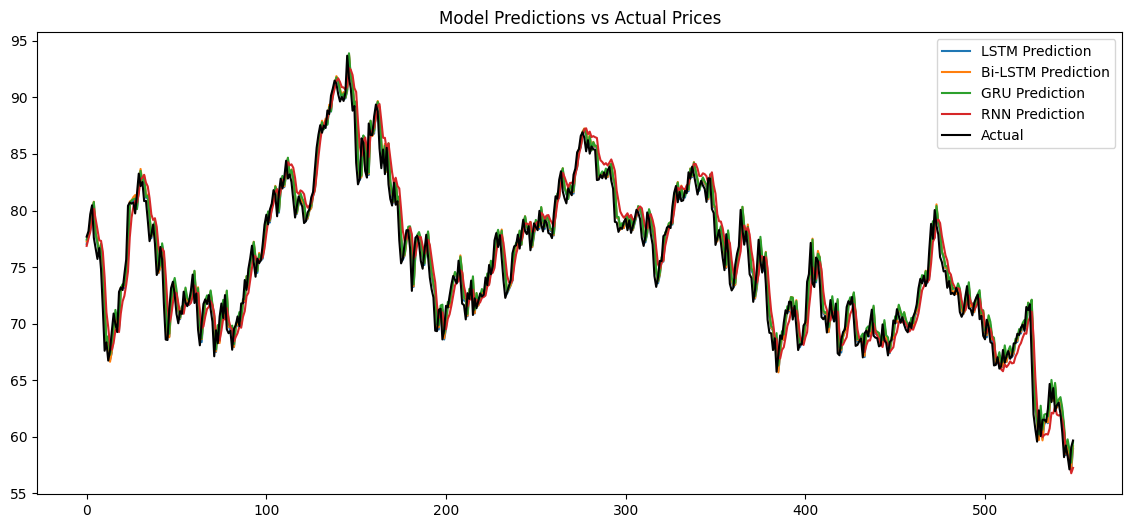

In [15]:
plt.figure(figsize=(14, 6))
for mtype in predictions:
    plt.plot(scaler.inverse_transform(predictions[mtype]), label=f'{mtype} Prediction')
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual', color='black')
plt.title('Model Predictions vs Actual Prices')
plt.legend()
plt.show()

Let's explain evaluation metrics:

- MAE (Mean Absolute Error): Average of absolute differences between predictions and actual values.

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

- RMSE (Root Mean Squared Error): Square root of the average squared differences — penalizes large errors more.

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

- R² Score (R-Squared): Measures how well predictions approximate the actual data (1 is perfect).

$$
R^2 = 1 - \frac{ \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }{ \sum_{i=1}^{n} (y_i - \bar{y})^2 }
$$

- MAPE (Mean Absolute Percentage Error): Measures error as a percentage, useful for interpretability.

$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$

Computing each metric for each model:

In [16]:
for model_type, y_pred in predictions.items():
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_true_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    r2 = r2_score(y_true_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)

    print(f"\n--- {model_type} ---")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAPE: {mape:.2%}")


--- LSTM ---
MAE: 1.1910
RMSE: 1.5092
R² Score: 0.9459
MAPE: 1.60%

--- Bi-LSTM ---
MAE: 1.2015
RMSE: 1.5348
R² Score: 0.9440
MAPE: 1.62%

--- GRU ---
MAE: 1.2054
RMSE: 1.5472
R² Score: 0.9431
MAPE: 1.62%

--- RNN ---
MAE: 1.4789
RMSE: 1.8819
R² Score: 0.9159
MAPE: 1.99%


##Observations

Based on the evaluation metrics and the plot, we can conclude that the all models performed well in predicting oil prices. They all show low error rates and high R² scores (all above 0.94 but RNN with R² score of 0.91), indicating strong correlation with actual prices. Among them, LSTM had the best overall performance with the lowest RMSE (1.5092) and highest R² (0.9459), meaning it captured both short- and long-term dependencies more effectively. The MAPE values for these models are also low (around 1.6% except for RNN which is 1.99%), reflecting high prediction accuracy in percentage terms.